In [2]:
#import packages
from statsbombpy import sb
import pandas as pd

/Users/megheaiani/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from collections import Counter



In [12]:
# --- Import required packages ---
from statsbombpy import sb
import pandas as pd

# LALIGA 2015-2016
competition_id = 11
season_id = 27

# --- Load all match IDs for the competition and season ---
matches = sb.matches(competition_id=competition_id, season_id=season_id)
match_ids = matches['match_id'].tolist()

# --- Download all events for these matches and extract assists ---
assists_list = []
for match_id in match_ids:
    df = sb.events(match_id=match_id, flatten_attrs=True)
    # Ensure 'pass_goal_assist' exists and fill missing with False
    if 'pass_goal_assist' not in df.columns:
        df['pass_goal_assist'] = False
    else:
        df['pass_goal_assist'] = df['pass_goal_assist'].fillna(False)
    # Filter for passes that are assists
    assists = df[(df['type'] == 'Pass') & (df['pass_goal_assist'] == True)]
    assists_list.append(assists)

# --- Concatenate all assists into a single DataFrame ---
df_assists = pd.concat(assists_list, ignore_index=True)

# --- (Optional) Reset index and inspect the result ---
df_assists.reset_index(drop=True, inplace=True)
print(f"Extracted {len(df_assists)} assists from competition {competition_id}, season {season_id}")
print(df_assists[['match_id', 'minute', 'player', 'team', 'pass_length', 'pass_angle', 'pass_height', 'pass_technique']].head())


/Users/megheaiani/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/megheaiani/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/var/folders/4m/2n3yzlf10012wdm94p3176pm0000gn/T/ipykernel_14712/785165724.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pass_goal_assist'] = df['pass_goal_assist'].fillna(False)
/Users/megheaiani/anaconda3/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/var/folders/4m/2n3yzlf10012wdm94p3176pm0000gn/T/ipykernel_14712/785165724

Extracted 722 assists from competition 11, season 27
   match_id  minute                     player        team  pass_length  \
0   3825848       9    Mauro Javier Dos Santos       Eibar    14.940549   
1   3825848      47               Takashi Inui       Eibar    11.482595   
2   3825848      51   Víctor Camarasa Ferrando  Levante UD    34.614594   
3   3825848      92  José Luis Morales Nogales  Levante UD    38.700130   
4   3825895      29     Sergio Ezequiel Araújo  Las Palmas    22.552383   

   pass_angle  pass_height pass_technique  
0    1.644488    High Pass            NaN  
1    2.151553  Ground Pass            NaN  
2    1.103273  Ground Pass            NaN  
3   -1.078255    High Pass            NaN  
4    1.035700  Ground Pass   Through Ball  


/Users/megheaiani/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


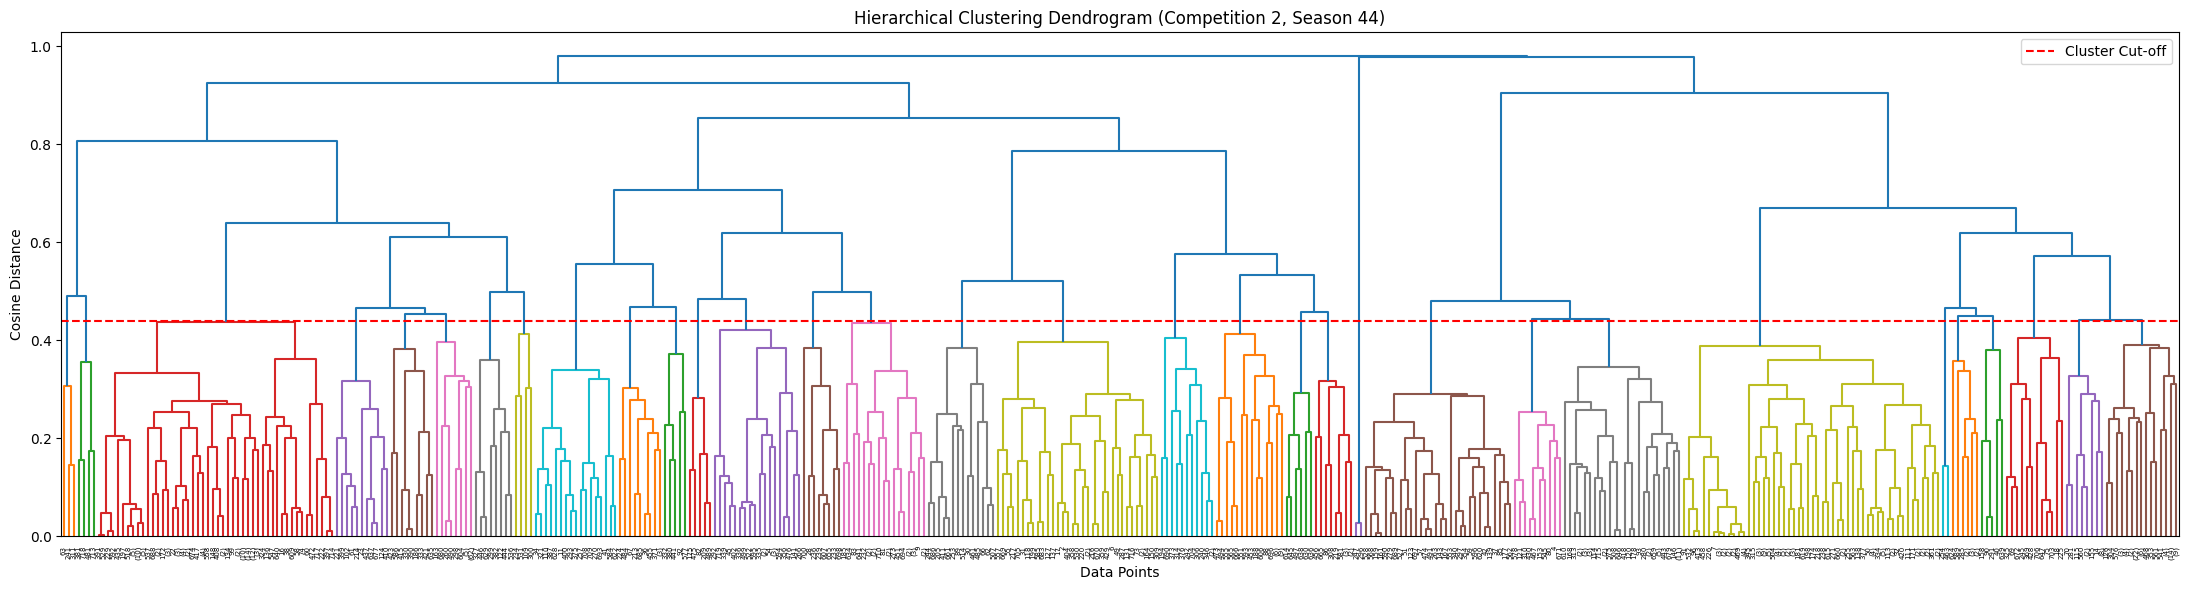

Cluster counts:
cluster
1       3
2       4
3     114
4      11
5       9
6      73
7       8
8       4
9      17
10     11
11      5
12      5
13     21
14      8
15     24
16     14
17     35
18     12
19     27
20      6
21     11
22      2
23     30
24     10
25     45
26     97
27      2
28     10
29      5
30     12
31     16
32     71
Name: count, dtype: int64


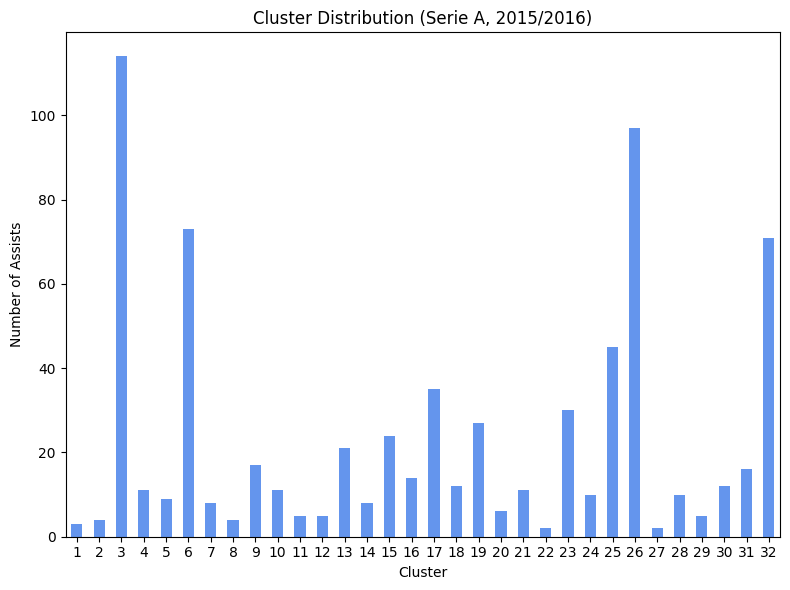

Total assists: 722
Through balls: 109 (15.1%)
High passes: 282 (39.1%)
Crosses: 225 (31.2%)
Short ground passes: 336 (46.5%)


/var/folders/4m/2n3yzlf10012wdm94p3176pm0000gn/T/ipykernel_37134/1357488086.py:92: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  n_cross = df_assists['pass_cross'].fillna(False).astype(bool).sum() if 'pass_cross' in df_assists else 0


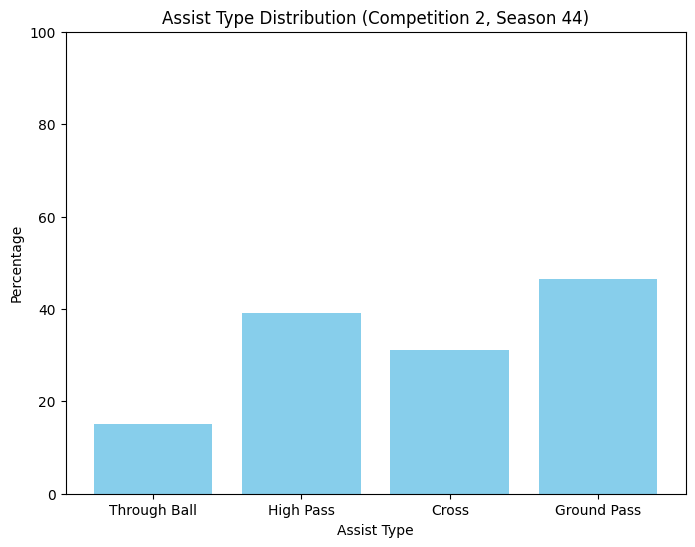

In [5]:
df_assists = pd.read_csv('laliga_2015_2016_assists.csv')
features = [
    'pass_length', 'pass_angle', 'pass_height', 'pass_deflected', 'under_pressure',
    'pass_end_location', 'location', 'pass_body_part', 'pass_technique',
    'play_pattern'
]



# Prepare the feature DataFrame
feature_df = pd.DataFrame({
    'pass_length': df_assists['pass_length'],
    'pass_angle': df_assists['pass_angle'],
    'pass_height': df_assists['pass_height'],
    'pass_deflected': df_assists['pass_deflected'].fillna(0).astype(int),
    'under_pressure': df_assists['under_pressure'].fillna(0).astype(int),
    'pass_start_x': df_assists['pass_start_x'],
    'pass_start_y': df_assists['pass_start_y'],
    'pass_end_x': df_assists['pass_end_x'],
    'pass_end_y': df_assists['pass_end_y'],
    'pass_body_part': df_assists['pass_body_part'],
    'pass_technique': df_assists['pass_technique'],
    'play_pattern': df_assists['play_pattern'],
})

# Ordinal encode pass_height
height_map = {'Ground Pass': 0, 'Low Pass': 1, 'High Pass': 2}
feature_df['pass_height'] = feature_df['pass_height'].map(height_map)

# One-hot encode categorical features
categorical = ['pass_body_part', 'pass_technique', 'play_pattern']
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded = encoder.fit_transform(feature_df[categorical].fillna('Unknown'))
encoded_cols = encoder.get_feature_names_out(categorical)
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=feature_df.index)

# Numerical features to scale
numerical = ['pass_length', 'pass_angle', 'pass_height', 'pass_deflected', 'under_pressure',
             'pass_start_x', 'pass_start_y', 'pass_end_x', 'pass_end_y']
scaler = StandardScaler()
scaled = scaler.fit_transform(feature_df[numerical])
scaled_df = pd.DataFrame(scaled, columns=numerical, index=feature_df.index)

# Combine all features for clustering
X = pd.concat([scaled_df, encoded_df], axis=1)

# --- 5. Hierarchical clustering and dendrogram ---
linked = linkage(X, method='average', metric='cosine')

plt.figure(figsize=(22, 6))
dendrogram(
    linked,
    truncate_mode="level", p=10,  # Show only top levels for readability
    color_threshold=0.44
)
plt.axhline(y=0.44, color='r', linestyle='--', label="Cluster Cut-off")
plt.title('Hierarchical Clustering Dendrogram (Competition 2, Season 44)')
plt.xlabel('Data Points')
plt.ylabel('Cosine Distance')
plt.legend()
plt.tight_layout()
plt.show()

# --- 6. Assign clusters at the same cutoff as your original study ---
cluster_labels = fcluster(linked, t=0.44, criterion='distance')
feature_df['cluster'] = cluster_labels
# Count assists in each cluster
cluster_counts = feature_df['cluster'].value_counts().sort_index()
print("Cluster counts:")
print(cluster_counts)
plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='cornflowerblue')
plt.title('Cluster Distribution (Serie A, 2015/2016)')
plt.xlabel('Cluster')
plt.ylabel('Number of Assists')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
# --- 7. Statistical analysis: percentage breakdowns ---
total = len(df_assists)
def pct(val): return 100 * val / total if total else 0

# Through balls
n_through = df_assists['pass_technique'].fillna('').str.contains('Through Ball').sum()
pct_through = pct(n_through)

# High passes
n_high = df_assists['pass_height'].eq('High Pass').sum()
pct_high = pct(n_high)

# Crosses
n_cross = df_assists['pass_cross'].fillna(False).astype(bool).sum() if 'pass_cross' in df_assists else 0
pct_cross = pct(n_cross)

# Short ground passes
n_ground = df_assists['pass_height'].eq('Ground Pass').sum()
pct_ground = pct(n_ground)

# Print summary
print(f"Total assists: {total}")
print(f"Through balls: {n_through} ({pct_through:.1f}%)")
print(f"High passes: {n_high} ({pct_high:.1f}%)")
print(f"Crosses: {n_cross} ({pct_cross:.1f}%)")
print(f"Short ground passes: {n_ground} ({pct_ground:.1f}%)")

import matplotlib.pyplot as plt

labels = ['Through Ball', 'High Pass', 'Cross', 'Ground Pass']
sizes = [pct_through, pct_high, pct_cross, pct_ground]

plt.figure(figsize=(8,6))
plt.bar(labels, sizes, color='skyblue')

plt.title('Assist Type Distribution (Competition 2, Season 44)')
plt.ylabel('Percentage')
plt.xlabel('Assist Type')

plt.ylim(0, 100)  # optional, if your percentages are in [0,100]
plt.show()

In [14]:
df_assists.to_csv('laliga_2015_2016_assists.csv', index=False)

In [15]:
# Amount of clusters
print(f"Number of clusters: {len(set(cluster_labels))}")


Number of clusters: 32
